# Great Ape Classifier

### Can a convolutional neural net fine-tuned on only a few hundred images tell the difference between Gorillas, Orangutangs and Chimpanzees?

In [3]:
%%capture

# imports
from fastai import *
from fastai.imports import *
from fastai.vision import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from fastbook import *

We will use Bing Image Search to get the data set. 

In [45]:
# bing api key
key = "dfae4de7193546ed98cb86a7fe55b470"

# lets download all the images 
apes = 'gorilla', 'orangutan', 'chimpanzee'

path = Path('apes')

#path.delete()
if not path.exists():
    path.mkdir()
    for ape in apes:
        dest = (path/ape)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{ape}')
        download_images(dest, urls=results.attrgot('contentUrl'))
        fns = get_image_files(path/ape)
        print(f'Downloaded {len(fns)} {ape} paintings')

Downloaded 137 gorilla paintings
Downloaded 147 orangutan paintings
Downloaded 144 chimpanzee paintings


In [53]:
# file names
fns = get_image_files(path)
print(len(fns))
fns

386


(#386) [Path('apes/orangutan/00000021.jpg'),Path('apes/orangutan/00000061.jpg'),Path('apes/orangutan/00000037.jpg'),Path('apes/orangutan/00000125.jpg'),Path('apes/orangutan/00000020.jpg'),Path('apes/orangutan/00000034.jpg'),Path('apes/orangutan/00000031.jpg'),Path('apes/orangutan/00000096.jpg'),Path('apes/orangutan/00000091.jpg'),Path('apes/orangutan/00000149.jpg')...]

In [54]:
# Removal of corrupt images (images that can't be opened) from data set
failed = verify_images(fns)
print(f"There are {len(fns)} images in the dataset. {len(failed)} are corrupt.")  
failed.map(Path.unlink)

There are 386 images in the dataset. 0 are corrupt.


(#0) []

In [55]:
# Define the datablock for creating data loadesrs
apes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # independent and dependent variable (X and target)
    get_items=get_image_files, # takes a path and returns list of all images in path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # use 20% of the images as validation set
    get_y=parent_label, # create labels from from folder image is in
    item_tfms=Resize(128) # images have to have same size as we are processing them batch-wise
)
apes

## Create dataloaders and a first look at data:

In [56]:
# create dataloaders from path
dls = apes.dataloaders(path)

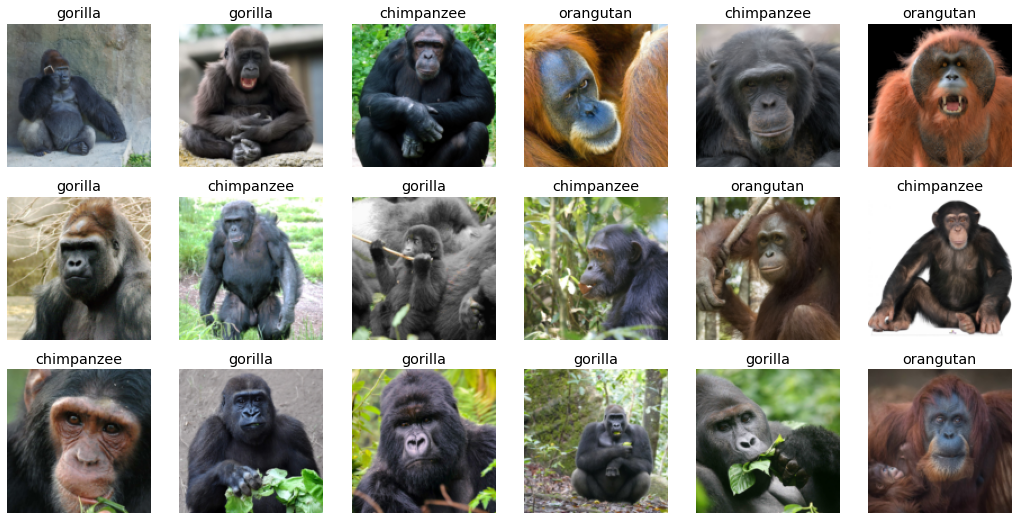

In [57]:
# lets look at a sample of data from the validation dataloader
dls.valid.show_batch(max_n=18, nrows=3)

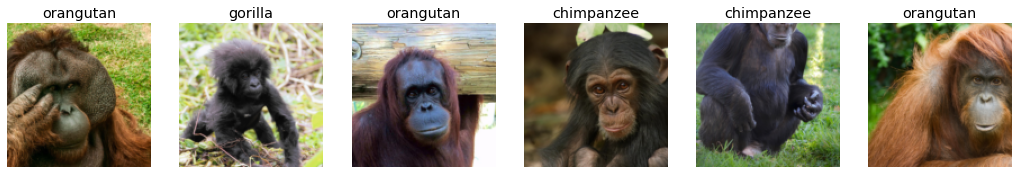

In [58]:
# lets look at a sample of data from the train dataloader
dls.train.show_batch(max_n=6, nrows=1)

## Resize and augment dataset

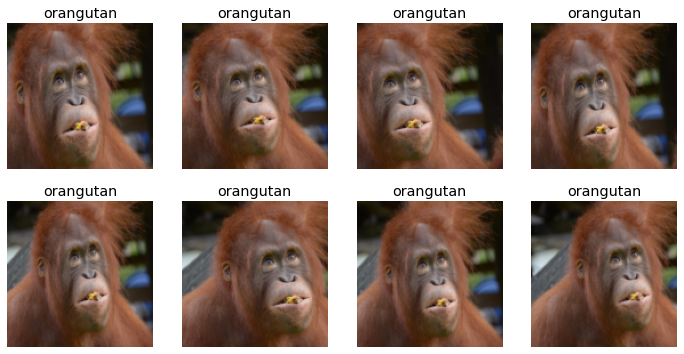

In [59]:
# To get the most out of the data set we augment it. 
# This is just to check the effect of RandomResizedCrop
apes = apes.new(item_tfms=RandomResizedCrop(128,min_scale=0.5))
dls = apes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Fine tune our model 

In [60]:
# our dataset is small so we use RandomResizedCrop and aug_transform to augment over data set
apes = apes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = apes.dataloaders(path)

## We use a Resnet18 CCN pretrained on imagenet. 
##### Below we fine-tune it on the great ape dataset

In [61]:
## creaate learner and fine-tune it for 6 epochs 
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.988778,0.455467,0.181818,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.737454,0.321129,0.090909,00:08
1,0.518602,0.228703,0.038961,00:08
2,0.373629,0.198350,0.038961,00:08
3,0.294998,0.174098,0.038961,00:08
4,0.237686,0.156022,0.038961,00:08
5,0.202611,0.162631,0.038961,00:09


Okay, so after 6 epochs traning  (around 1 minute) we have an error-rate of 4% on the validation set. 96% of the image in the validaion are classified correctly!

## Lets use our model to clean our data

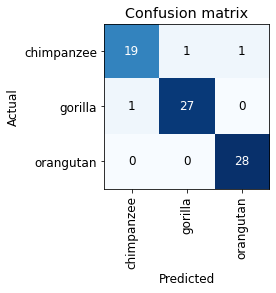

In [72]:
# confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

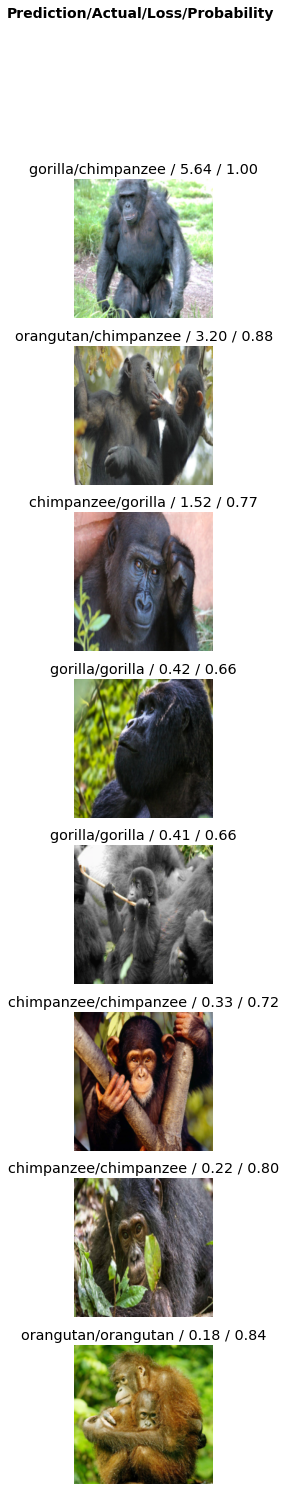

In [70]:
# images with most loss (Where our model was most in doubt). 
# Sometimes this is wrongly labeled images that need to be moved or simply bad data points that needs to be deleted
interp.plot_top_losses(8, nrows=8)

In [71]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [85]:
# delete images selected for deletion
for idx in cleaner.delete():cleaner.fns[idx].unlink()

We see that one 3 of the images in the validation set are classified incorrectly. For example, 1 chimp has been classified as an orangutan. 

 ## Using our model for inference 

In [85]:
# The model can be saved and reimported
learn.export()
path = Path()
print(path.ls())
# let's confirm that the new file exists
path.ls(file_exts='.pkl')

[Path('great_ape_classifier.ipynb'), Path('.gitignore'), Path('apes'), Path('export.pkl'), Path('.ipynb_checkpoints')]


(#1) [Path('export.pkl')]

In [86]:
# import leaner
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab

['chimpanzee', 'gorilla', 'orangutan']

In [75]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

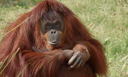

In [77]:
# Let's try our classifier on a photo of a orangutan I found on the internet
image = PILImage.create(btn_upload.data[-1])
image.to_thumb(128,128)


In [78]:
# make prediction on sample image
pred, pred_idx, probs = learn_inf.predict(image)
print(f'This is a {pred}. Probability is {probs[pred_idx]:.04}.')

This is a orangutan. Probability is 1.0.


In [79]:
btn_upload2 = widgets.FileUpload()
btn_upload2

FileUpload(value={}, description='Upload')

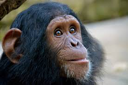

In [80]:
# Let's try our classifier on a photo of a chimpanzee I found on the internet
image2 = PILImage.create(btn_upload2.data[-1])
image2.to_thumb(128,128)

In [81]:
# make prediction on sample image
pred, pred_idx, probs = learn_inf.predict(image2)
print(f'This is a {pred}. Probability is {probs[pred_idx]:.04}.')

This is a chimpanzee. Probability is 0.9889.


In [82]:
btn_upload3 = widgets.FileUpload()
btn_upload3


FileUpload(value={}, description='Upload')

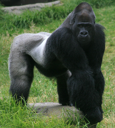

In [83]:
# Let's try our classifier on a photo of a gorilla I found on the internet
image3 = PILImage.create(btn_upload3.data[-1])
image3.to_thumb(128,128)

In [84]:
pred, pred_idx, probs = learn_inf.predict(image3)
print(f'This is a {pred}. Probability is {probs[pred_idx]:.04}.')

This is a gorilla. Probability is 1.0.
